In [1]:
import matplotlib as mpl
import pandas as pd
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
root_dir = os.path.dirname(os.getcwd())

In [3]:

def get_result(metric, dataid = 1, num_shot = 1, model = 'gill'):
    results_dir = os.path.join(root_dir, 'results')
    if metric == 'llava':
        results_dir = os.path.join(results_dir, 'llava_evaluation')
    elif metric == 'clip':
        results_dir = os.path.join(results_dir, 'clip_evaluation')
    else:
        raise ValueError('Invalid metric')
    
    # find all the files in the directory
    files = os.listdir(results_dir)
    for file in files:
        if f'[{dataid}]' in file and f'{model}_{num_shot}shot' in file:
            file_path = os.path.join(results_dir, file)
    
            # get the numbers between the first parantheses in the file name
            value = file_path.split('(')[1].split(')')[0]
            return float(value)
    return None

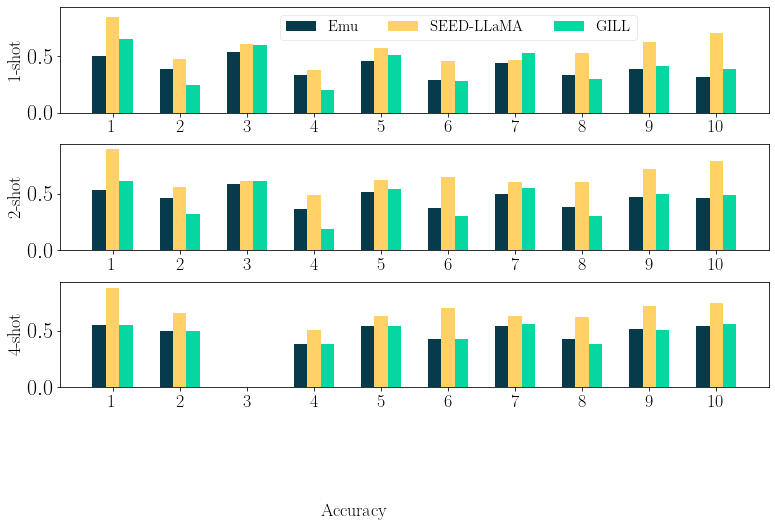

In [10]:
metric = 'llava'

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 2.5
markers = ['s', 'o']
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
models = ['Emu', 'SEED-LLaMA', 'GILL']
lts = ['--', '-']
marker_sizes = [6, 5]
shots = [1,2,4]

fig, ax = plt.subplots(nrows = 3, ncols = 1, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(12, 8) #exact size of the figure

# Plotting bar plots for each cluster
clusters = range(1, 11)  # Clusters from 1 to 11
bar_width = 0.2  # Width of each bar

model_str = {
    'Emu': 'emu',
    'SEED-LLaMA': 'seed',
    'GILL': 'gill'
}

for row, num_shot in enumerate(shots):
    for i, cluster in enumerate(clusters):   
        for j, model in enumerate(models):     
            value = get_result(metric, cluster, num_shot, model_str[model])
            if value:
                ax[row].bar(i + j*bar_width, value, width=bar_width, color=colors[j % len(colors)], label = models[j])
            if i == 0 and row == 0:
                ax[row].legend(bbox_to_anchor=(0.3, 1), ncol=3, fontsize=15)

    ax[row].set_xticks([i + bar_width for i in range(len(clusters))])
    ax[row].set_xticklabels(clusters, fontsize=18)
    ax[row].set_ylabel(f'{num_shot}-shot', fontsize=18)

fig.supxlabel('Accuracy', fontsize=18)
fig.savefig(f'{root_dir}/figures/basic_llava_acc.pdf')
# Show the plot
plt.show()

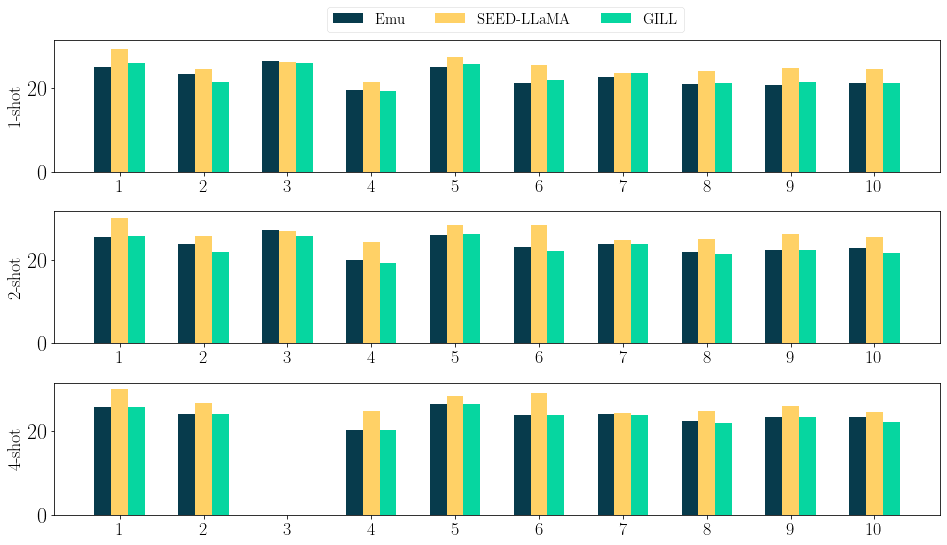

In [5]:
metric = 'clip'

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 2.5
markers = ['s', 'o']
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
models = ['Emu', 'SEED-LLaMA', 'GILL']
lts = ['--', '-']
marker_sizes = [6, 5]
shots = [1,2,4]

fig, ax = plt.subplots(nrows = 3, ncols = 1, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(15, 10) #exact size of the figure

# Plotting bar plots for each cluster
clusters = range(1, 11)  # Clusters from 1 to 11
bar_width = 0.2  # Width of each bar

model_str = {
    'Emu': 'emu',
    'SEED-LLaMA': 'seed',
    'GILL': 'gill'
}

for row, num_shot in enumerate(shots):
    for i, cluster in enumerate(clusters):   
        for j, model in enumerate(models):     
            value = get_result(metric, cluster, num_shot, model_str[model])
            if value:
                ax[row].bar(i + j*bar_width, value, width=bar_width, color=colors[j % len(colors)], label = models[j])
            if i == 0 and row == 0:
                ax[row].legend(bbox_to_anchor=(0.3, 1), ncol=3, fontsize=15)

    ax[row].set_xticks([i + bar_width for i in range(len(clusters))])
    ax[row].set_xticklabels(clusters, fontsize=18)
    ax[row].set_ylabel(f'{num_shot}-shot', fontsize=18)


# Show the plot
plt.show()

In [6]:
def get_images(
    model, 
    num_shot, 
    latent, 
    image_name, 
    dataid, 
    metric,
    task_category,
    task_subcategory,
):
    value_folder = f"{root_dir}/results/{metric}_evaluation/detail"
    image_folder = f"{root_dir}/results/{model}_results/shot_{num_shot}/{task_category}/{task_subcategory}"
    
    # get value file
    value_files = os.listdir(value_folder)
    score = None
    for file in value_files:
        file_condition1 = f'{dataid}' in file
        file_condition2 = f'{model}_{num_shot}shot_{latent}' in file
        if file_condition1 and file_condition2:
            value_file = os.path.join(value_folder, file)
            with open(value_file, 'r') as file:
                values = json.load(file)
                
            for value in values:
                if value['name'] == image_name:
                    score = value['score']
        
    # get image file
    image = None
    image_file = f"{image_folder}/{image_name}"
    image = plt.imread(image_file)
        
    return {'image': image, 'score': score}

In [7]:
get_images(
    model = 'gill',
    num_shot = 1, 
    latent = 'bag', 
    image_name = 'black_pink_result.jpg', 
    dataid = 1, 
    metric = 'llava',
    task_category = 'color_object',
    task_subcategory = 'color_bag',
)

FileNotFoundError: [Errno 2] No such file or directory: '/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/micl/results/gill_results/shot_1/color_object/color_bag/black_pink_result.jpg'

In [ ]:
plt.imread('/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/micl/results/gill_results/shot_1/color_object/color_bag/black_pink_result.jpg')